In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt



## TRANSFORMERS



# Data and input Pipline


In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0ZSGUZ/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0ZSGUZ/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0ZSGUZ/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
[en.numpy() for pt, en in train_examples.take(10)]

[b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
 b'but what if it were active ?',
 b"but they did n't test for curiosity .",
 b'and this conscious defiance is why i , as an agnostic , can still have faith .',
 b'you can use everything on the table on me .',
 b"`` i write a lot about `` '' security theater , '' '' which are products that make people feel secure , but do n't actually do anything . ''",
 b"and they 've put it deep down in an iron mine in minnesota , ok , deep under the ground , and in fact , in the last couple of days announced the most sensitive results so far .",
 b'see , some people might fear girls not liking them back .',
 b"no , what happened to us , chris , is that power , it 's priced off the margin .",
 b'back to my question : why did i stay ?']

In [5]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [6]:
sample_string = 'Transformer is complicated.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 3635, 7877]
The original string: Transformer is complicated.
7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
3635 ----> complicated
7877 ----> .


In [7]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [8]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [9]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Drop example where the tokenization of either language is greater then 40
This is to keep things fast should work without this 

In [10]:
MAX_LENGTH = 40

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [12]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [13]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

# Positional Encoding


In [14]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [15]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [16]:
d_model = 512
dff=2048
maximum_position_encoding = 10000
input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2

scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))

# Encoder

input = tf.keras.layers.Input(shape=(None,))
x = tf.keras.layers.Embedding(input_vocab_size, d_model)(input) #Mask=None

# Positional encoding

x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]] )

# Self-attention

query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention()([query, value, key])    
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Feed Forward

dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])                                          # residual connection
encoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Decoder

target = tf.keras.layers.Input(shape=(None,))
x = tf.keras.layers.Embedding(target_vocab_size, d_model )(target) 

# Positional encoding

x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :] ])

# Self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention(causal = True)([query, value, key])       #Mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])                                      # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Encoder-decoder attention

query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(encoder)
key = tf.keras.layers.Dense(d_model)(encoder)
attention = tf.keras.layers.Attention()([query, value, key])                    #Mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])                                      # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])                                          # residual connection
decoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

######################################################

x = tf.keras.layers.Dense(target_vocab_size,activation='softmax')(decoder)


base_model = tf.keras.models.Model(inputs=[input,target], outputs=x)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    4206592     ['input_1[0][0]']                
                                                                                                  
 multiply (Multiply)            (None, None, 512)    0           ['embedding[0][0]']              
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['multiply[0][0]']               
 )                                                                                            

In [17]:
optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

base_model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [18]:
def generator(data_set):
  while True:
    for pt_batch, en_batch in data_set:
      yield ( [pt_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )


num_batches = 100
val_batches = 100

history = base_model.fit(x = generator(train_dataset), validation_data = generator(val_dataset), epochs=50, steps_per_epoch = num_batches, validation_steps = val_batches)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


100/100 [==============================] - 51s 455ms/step - loss: 3.2462 - sparse_categorical_accuracy: 0.5581 - val_loss: 3.0013 - val_sparse_categorical_accuracy: 0.5619
Epoch 2/50
100/100 [==============================] - 43s 428ms/step - loss: 2.9988 - sparse_categorical_accuracy: 0.5722 - val_loss: 2.5427 - val_sparse_categorical_accuracy: 0.6409
Epoch 3/50
100/100 [==============================] - 40s 398ms/step - loss: 2.3898 - sparse_categorical_accuracy: 0.6475 - val_loss: 2.2932 - val_sparse_categorical_accuracy: 0.6558
Epoch 4/50
100/100 [==============================] - 37s 371ms/step - loss: 2.2624 - sparse_categorical_accuracy: 0.6549 - val_loss: 2.2218 - val_sparse_categorical_accuracy: 0.6613
Epoch 5/50
100/100 [==============================] - 34s 340ms/step - loss: 2.1963 - sparse_categorical_accuracy: 0.6616 - val_loss: 2.1734 - val_sparse_categorical_accuracy: 0.6648
Epoch 6/50
100/100 [==============================] - 29s 295ms/step - loss: 2.1643 - sparse_cat

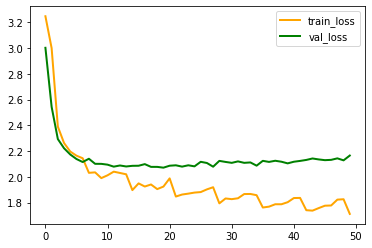

In [19]:
plt.plot(history.history['loss'],label='train_loss',color='orange',lw=2)
plt.plot(history.history['val_loss'],label='val_loss',color='green',lw=2)
plt.legend()

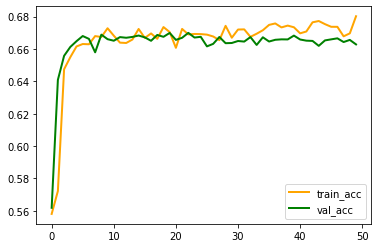

In [20]:
plt.plot(history.history['sparse_categorical_accuracy'],label='train_acc',color='orange',lw=2)
plt.plot(history.history['val_sparse_categorical_accuracy'],label='val_acc',color='green',lw=2)
plt.legend()

In [21]:
for i in range(10):
  translation = [tokenizer_en.vocab_size]
  

  for _ in range(40):
    predict = base_model.predict([pt_batch[i:i+1],np.asarray([translation])])
    translation.append(np.argmax(predict[-1,-1]))
    if translation[-1] == tokenizer_en.vocab_size + 1:
      break

  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print(generator(val_dataset))
  print(tokenizer_en.decode(real_translation))
  print(tokenizer_en.decode(translation[1:-1]))
  print("")


<generator object generator at 0x7fb1f86af7d0>
did they eat fish and chips ?
so what about the world .

<generator object generator at 0x7fb1f750d850>
i was always worried about being caught and sent back .
and the problem is that the most important and the most important thing that we have to be able to be able to be able to get to be able to get them to be right .

<generator object generator at 0x7fb1f750ddd0>
i chose one with the skin color of a lobster when sunburnt .
and i was a few years ago , but they have been a little bit of the same time .

<generator object generator at 0x7fb1f750d650>
but i think this is quite clearly untrue .
but it is a very difficult to be a little bit of the world .

<generator object generator at 0x7fb1f750d1d0>
we have measured our progress very rigorously .
and i was a few years ago , the world is a little bit of the world .

<generator object generator at 0x7fb1f86af7d0>
and from what i feel , it 's a cure for me , but for us all .
but the problem 